In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import open_clip
import random
import os
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Load the BiomedCLIP model and preprocess functions
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Load tokenizer 
tokenizer = open_clip.get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

open_clip_pytorch_model.bin:   0%|          | 0.00/784M [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

G:\anaconda3\envs\MEDCAT\Lib\site-packages\open_clip\factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_

In [3]:
# Define file paths
test_caption_file = "../Datasets/MEDICAT SAMPLES/sample.jsonl"
test_image_folder = "../Datasets/MEDICAT SAMPLES/figures"

# Load JSONL file into a DataFrame
test_df_subset = pd.read_json(test_caption_file, lines=True)

# Select relevant columns and rename them
test_df_subset = test_df_subset[['pdf_hash', 'fig_key', 'fig_uri', 's2_caption']]
test_df_subset.columns = ['PDF_Hash', 'Fig_Key', 'Image_URI', 'Caption']

# Construct the full image filename with PDF hash and Figure key
test_df_subset['Image'] = test_df_subset.apply(
    lambda row: f"{row['PDF_Hash']}_{row['Image_URI'].split('/')[-1]}",
    axis=1
)

# Add the full path to the image filename
test_df_subset['Image'] = test_image_folder + '/' + test_df_subset['Image']

# Display the DataFrame
test_df_subset


,PDF_Hash,Fig_Key,Image_URI,Caption,Image
0,26491ab76c6e8d6acc582e71bb6b3b5f5601ccc2,Figure4,3-Figure4-1.png,Figure 4. Nuclear magnetic resonance scan demo...,../Datasets/MEDICAT SAMPLES/figures/26491ab76c...
1,57c9ad0f4aab133f96d40992c46926fabc901ffa,Figure1,2-Figure1-1.png,Figure 1. (A) Barium enema and (B) endoscopic ...,../Datasets/MEDICAT SAMPLES/figures/57c9ad0f4a...
2,57c9ad0f4aab133f96d40992c46926fabc901ffa,Figure3,2-Figure3-1.png,Figure 3. Surveillance colonoscopy 1 year afte...,../Datasets/MEDICAT SAMPLES/figures/57c9ad0f4a...
3,57c9ad0f4aab133f96d40992c46926fabc901ffa,Figure2,2-Figure2-1.png,Figure 2. Complete resolution of the colonic o...,../Datasets/MEDICAT SAMPLES/figures/57c9ad0f4a...
4,57c9ad0f4aab133f96d40992c46926fabc901ffa,Figure4,2-Figure4-1.png,Figure 4. Endoscopic images 4 years after colo...,../Datasets/MEDICAT SAMPLES/figures/57c9ad0f4a...
5,b362a19e4c4b1854f7cbe246a19502a56f52c2b5,Figure2,3-Figure2-1.png,Figure 2. Abdominal CT image of a rabbit revea...,../Datasets/MEDICAT SAMPLES/figures/b362a19e4c...
6,e19039cd42f72102389f811643cd3036f8db5182,Figure3,2-Figure3-1.png,Fig 3. Control computed tomography (CT) angiog...,../Datasets/MEDICAT SAMPLES/figures/e19039cd42...
7,e19039cd42f72102389f811643cd3036f8db5182,Figure1,2-Figure1-1.png,Fig 1. Computed tomography (CT) angiogram with...,../Datasets/MEDICAT SAMPLES/figures/e19039cd42...
8,5f2d2f2ffbd20c7ff3ac30d514da54ee5bd825b4,Figure1,1-Figure1-1.png,Fig. 1. Brain CT (A) and MR diffusion images (...,../Datasets/MEDICAT SAMPLES/figures/5f2d2f2ffb...
9,5f2d2f2ffbd20c7ff3ac30d514da54ee5bd825b4,Figure2,2-Figure2-1.png,"Fig. 2. Mid sagittal (A, C) and axial MRI (B, ...",../Datasets/MEDICAT SAMPLES/figures/5f2d2f2ffb...


In [5]:
context_length = 256
# Load and preprocess images
images = torch.stack([preprocess_val(Image.open( img)) for img in test_df_subset['Image']]).to(device)

# Tokenize captions
captions = tokenizer([caption for caption in test_df_subset['Caption']], context_length=context_length).to(device)

In [6]:
with torch.no_grad():
    image_features, caption_features, logits= model(images, captions)


G:\anaconda3\envs\MEDCAT\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(


In [7]:
print("Image features shape:", image_features.shape)
print("Caption features shape:", caption_features.shape)

Image features shape: torch.Size([10, 512])
Caption features shape: torch.Size([10, 512])


In [8]:
# Move tensors to CPU and convert to numpy arrays
image_features_np = image_features.cpu().numpy()
caption_features_np = caption_features.cpu().numpy()

# Compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(image_features_np, caption_features_np)

# Prepare labels
image_labels = test_df_subset['Image'].tolist()
caption_labels = test_df_subset['Caption'].tolist()

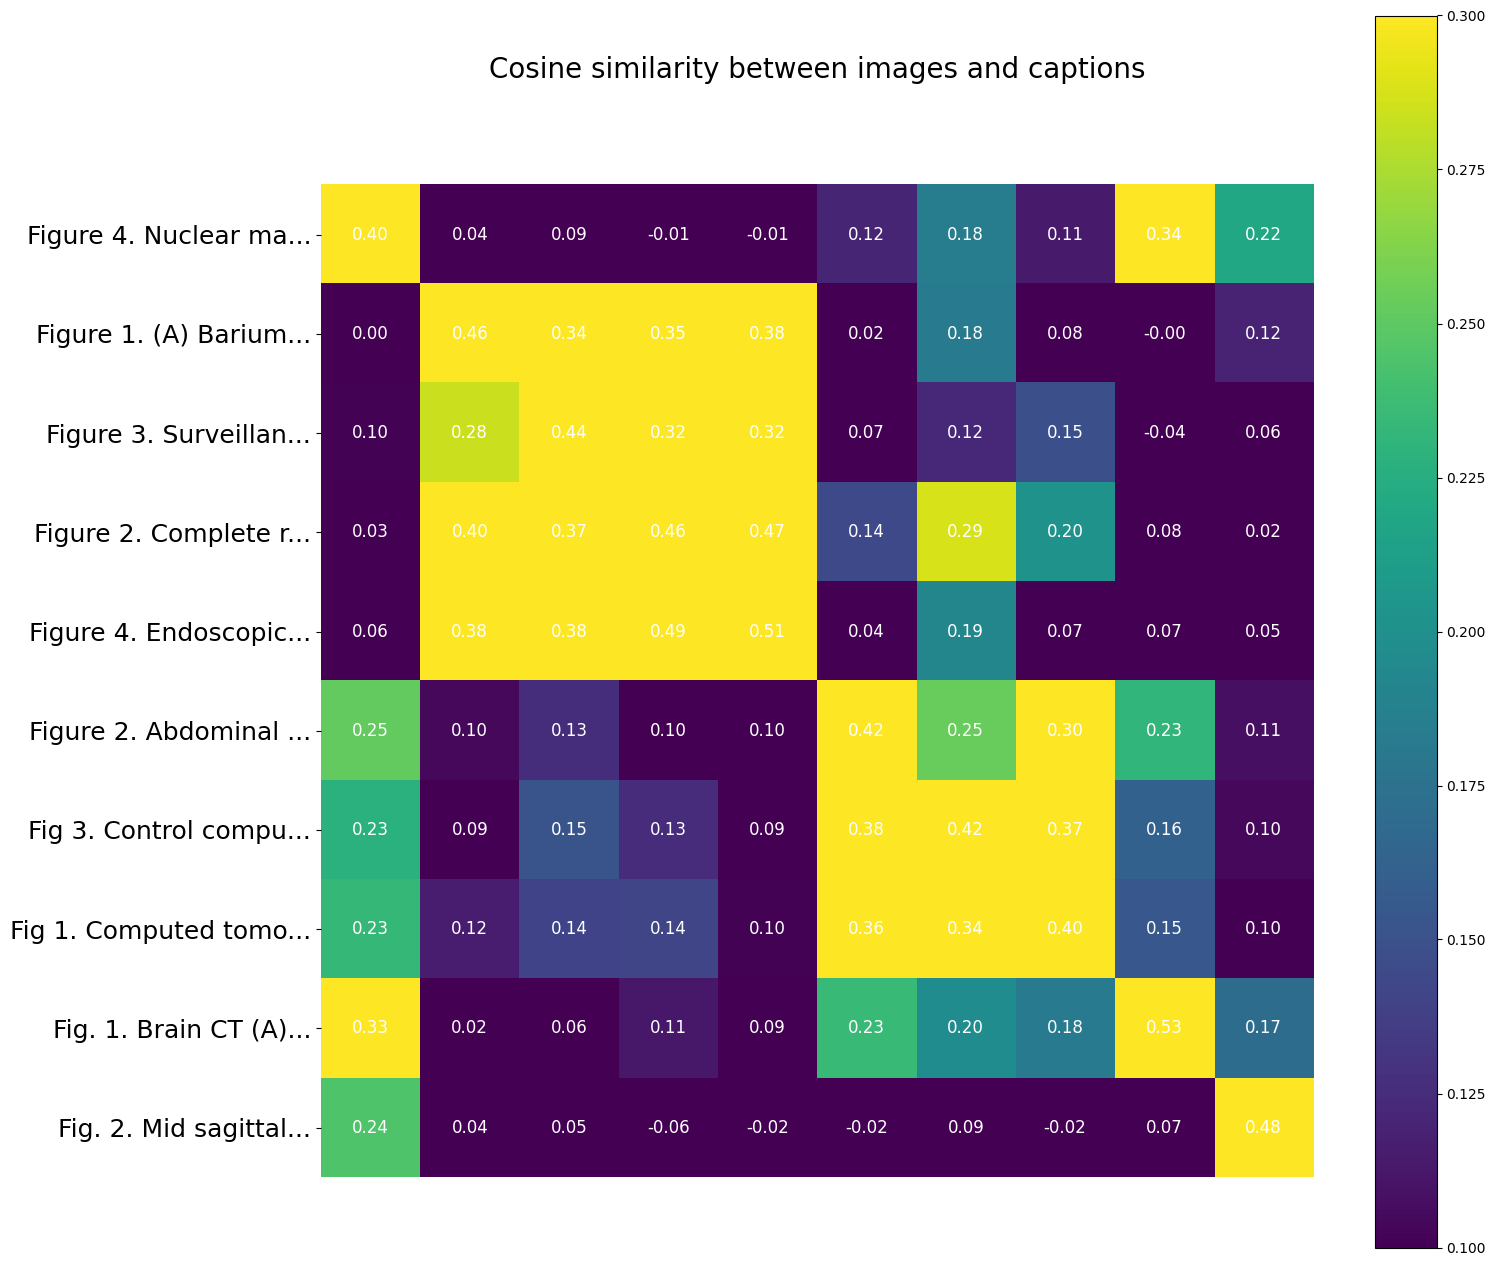

In [9]:
def load_images_from_folder(folder_path, image_labels, size=(64, 64)):
    images = []
    for label in image_labels:
        img_path = os.path.join(folder_path, label)
        if os.path.exists(img_path):
            img = Image.open(img_path).resize(size)  # Resize image for better display
            images.append(img)
    return images

def shorten_labels(labels, max_length=20):
    return [label if len(label) <= max_length else label[:max_length] + '...' for label in labels]

def plot_heatmap(cosine_sim_matrix, image_labels, caption_labels, image_folder, title="Cosine similarity between images and captions"):
    # Shorten captions
    shortened_captions = shorten_labels(caption_labels)

    # Load images
    images = load_images_from_folder(image_folder, image_labels, size=(64, 64))

    count = len(shortened_captions)
    
    plt.figure(figsize=(16, 16))  # Adjust figsize to ensure each cell is large enough
    plt.imshow(cosine_sim_matrix, cmap='viridis', vmin=0.1, vmax=0.3)
    
    # Display images at the bottom
    for i, img in enumerate(images):
        plt.imshow(img, extent=(i - 0.5, i + 0.5, -0.5, -1.5), origin="lower")  # Adjust extent to position images properly
    
    # Display text annotations
    for x in range(cosine_sim_matrix.shape[1]):
        for y in range(cosine_sim_matrix.shape[0]):
            plt.text(x, y, f"{cosine_sim_matrix[y, x]:.2f}", ha="center", va="center", size=12, color='white')
    
    # Customize axes
    plt.yticks(range(count), shortened_captions, fontsize=18)
    plt.xticks([])
    
    # Hide spines
    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)
    
    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count - 0.5, -1.5])  # Adjust limits to fit the images and text
    
    plt.title(title, size=20)
    plt.colorbar()  # Optional: Display colorbar if needed

    plt.show()


plot_heatmap(cosine_sim_matrix, image_labels, caption_labels, test_image_folder)

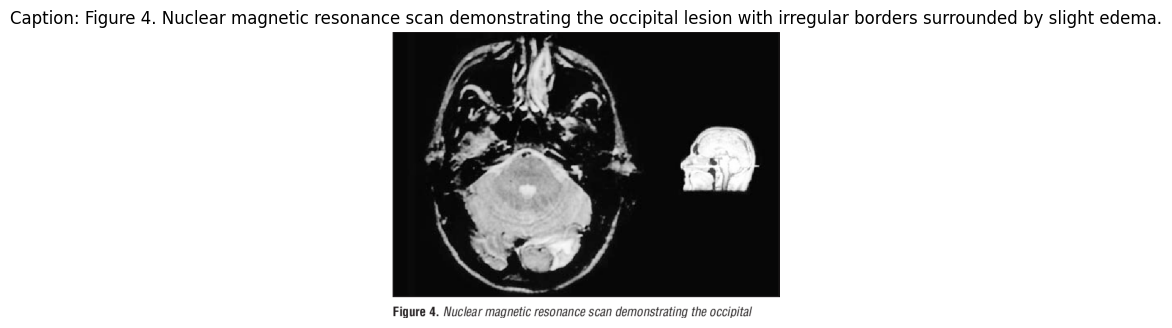

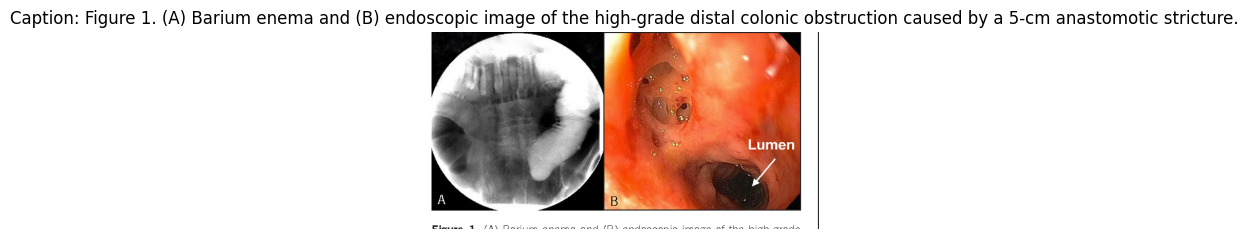

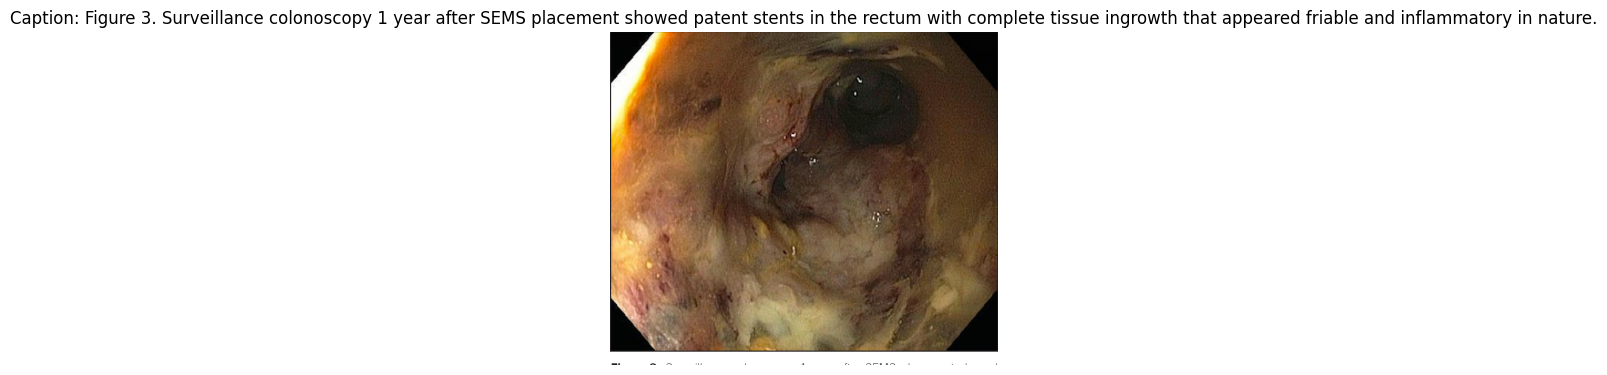

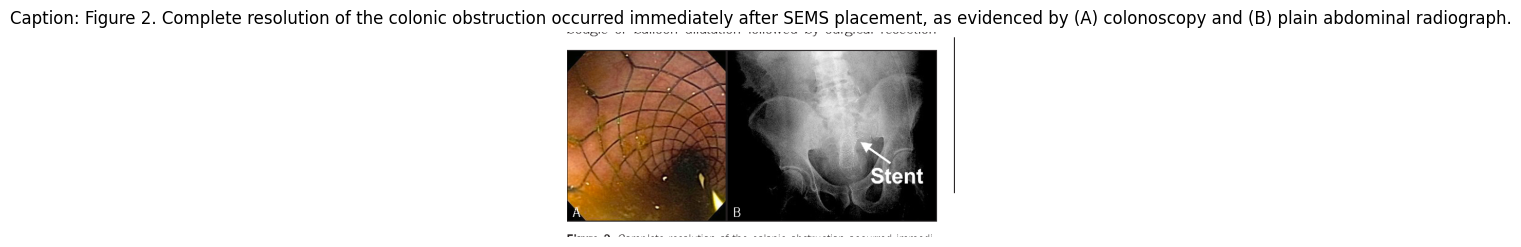

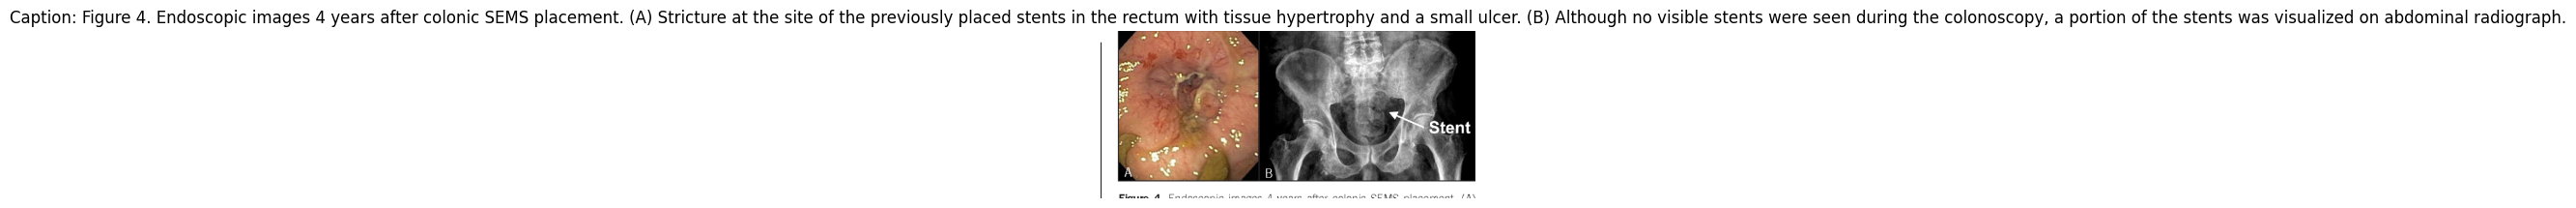

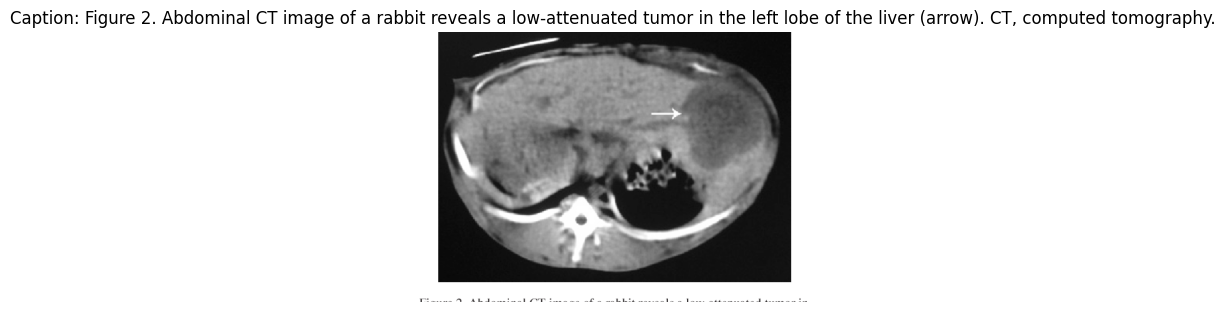

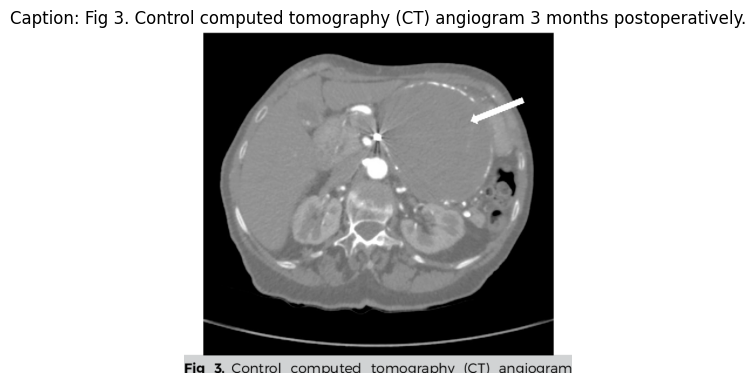

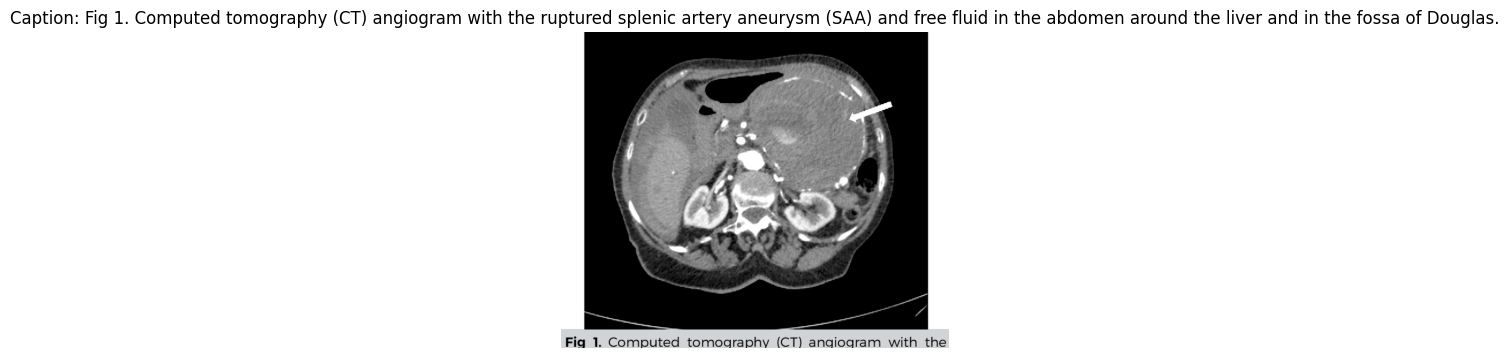

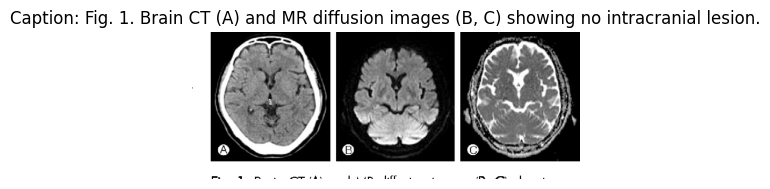

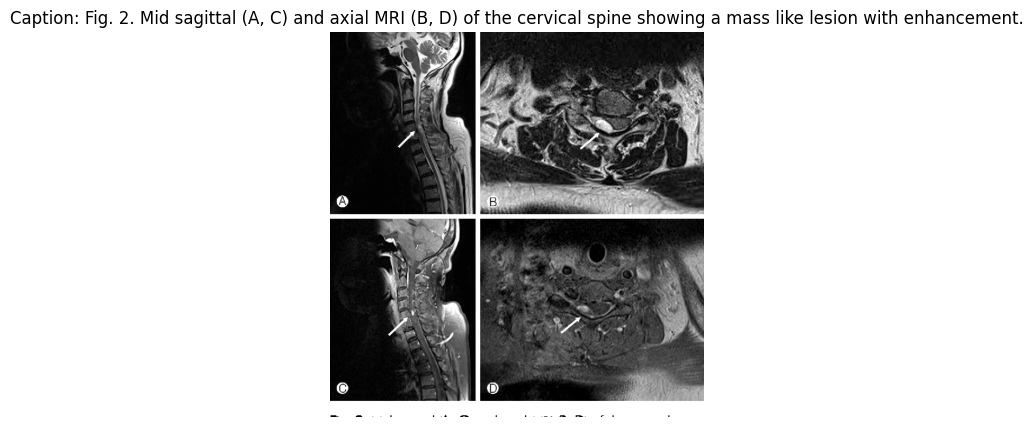

In [12]:
num_samples = 10
# Print the Image + the caption underneath for each 10 samples using seaborn
for i in range(num_samples):
    img_path = (test_df_subset.loc[i, 'Image'])
    img = Image.open(img_path)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Caption: {test_df_subset.loc[i, 'Caption']}", fontsize=12)
    plt.axis('off')
    plt.show()